In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/club-football-match-data-2000-2025/Matches.csv
/kaggle/input/club-football-match-data-2000-2025/EloRatings.csv
/kaggle/input/epl-dataset-csv/EPL.csv
/kaggle/input/epl-with-labels-matchday/EPL.csv


# *DATA PREPROCESSING AND FEATURE ENGINEERING* 

In [2]:
def preprocess_data(path):
    """
    Preprocess the data by loading it from a CSV file, renaming columns, and converting data types.
    """
    df = pd.read_csv(path)
    df.sort_values(['date'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df['result'] = pd.to_numeric(df['result'].replace({'w': 3, 'd': 1, 'l': 0}), errors='coerce')
    df['result'] = df['result'].fillna(0).round().astype(int)
    df.head(20)

    # Safe division function
    def safe_divide(a, b):
        return np.divide(a, b, out=np.zeros_like(a), where=b!=0)

    # Create team views with safe calculations
    team_cols = ['date', 'team', 'team_form', 'xG', 'shots', 'shotOnTarget', 'deep', 'is_home', 'possession_proxy', 'final_pos']
    
    df_home = df.assign(
        team=df['home_team'],
        team_form=df['result'],
        is_home=1,
        final_pos= df['home_final_pos'],
        possession_proxy=(
            0.3 * safe_divide(df['xG_home'], df['xG_home']+df['xG_away']) +
            0.3 * safe_divide(df['home_shots'], df['home_shots']+df['away_shots']) +
            0.4 * safe_divide(df['home_deep'], df['home_deep']+df['away_deep'])
        )
    ).rename(columns={
        'xG_home': 'xG',
        'home_shots': 'shots',
        'home_shotOnTarget': 'shotOnTarget',
        'home_deep': 'deep'
    })[team_cols]

    df_away = df.assign(
        team=df['away_team'],
        team_form=df['result'].replace({3: 0, 0: 3}),
        is_home=0,
        final_pos= df['away_final_pos'],
        possession_proxy=(
            0.3 * safe_divide(df['xG_away'], df['xG_home']+df['xG_away']) +
            0.3 * safe_divide(df['away_shots'], df['home_shots']+df['away_shots']) +
            0.4 * safe_divide(df['away_deep'], df['home_deep']+df['away_deep'])
        )
    ).rename(columns={
        'xG_away': 'xG',
        'away_shots': 'shots',
        'away_shotOnTarget': 'shotOnTarget',
        'away_deep': 'deep'
    })[team_cols]

    # Combine and sort
    df_team = pd.concat([df_home, df_away]).sort_values(['team','date']).reset_index(drop=True)

    # Calculate rolling features
    stats = ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']
    for stat in stats:
        df_team[f'rolling_{stat}'] = (
            df_team.groupby('team')[stat]
            .transform(lambda x: x.rolling(window=5, min_periods=1).mean().shift(1))
            # Optional: fill initial NaN per team
            .fillna(0)
        )
    return df_team, df


In [3]:
team_df, match_df = preprocess_data('/kaggle/input/epl-with-labels-matchday/EPL.csv')
team_df.groupby('team', as_index=False).head(50)
match_df.head(5)

/tmp/ipykernel_31/47173307.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['result'] = pd.to_numeric(df['result'].replace({'w': 3, 'd': 1, 'l': 0}), errors='coerce')
/usr/local/lib/python3.11/dist-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


,date,home_team,away_team,home_goals,away_goals,is_home,xG_home,xG_away,home_shots,away_shots,home_shotOnTarget,away_shotOnTarget,home_deep,away_deep,result,home_final_pos,away_final_pos
0,2014-08-16,Manchester United,Swansea,1,2,1,1.166350,0.278076,14,5,5,4,8,2,0,4,8
1,2014-08-16,West Ham,Tottenham,0,1,1,1.853100,1.017060,18,10,4,4,9,3,3,12,5
2,2014-08-16,Arsenal,Crystal Palace,2,1,1,1.554110,0.158151,14,4,6,2,9,0,3,3,10
3,2014-08-16,Stoke,Aston Villa,0,1,1,0.423368,0.909774,12,7,2,1,3,4,0,9,17
4,2014-08-16,Leicester,Everton,2,2,1,1.278300,0.613273,11,13,3,3,1,15,1,14,11


In [4]:
def merge(match_df, team_df):
    # print(team_df.columns.tolist())
    prepared_df = match_df.merge(
        team_df[team_df['is_home']==1][['date', 'team', *[f'rolling_{stat}' for stat in ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']]]],
        left_on=['date', 'home_team'],
        right_on=['date', 'team'],
        suffixes=('', '_home')
    )
    prepared_df = prepared_df.merge(
        team_df[team_df['is_home']==0][['date', 'team', *[f'rolling_{stat}' for stat in ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']]]],
        left_on=['date', 'away_team'],
        right_on=['date', 'team'],
        suffixes=('', '_away')
    )
    return prepared_df



In [5]:
prepared_df = merge(match_df, team_df)
team_df.groupby('team').first()

,date,team_form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,final_pos,rolling_xG,rolling_shots,rolling_shotOnTarget,rolling_deep,rolling_team_form,rolling_possession_proxy
team,,,,,,,,,,,,,,,
Arsenal,2014-08-16,3,1.554110,14,6,9,1,0.672291,3,0.0,0.0,0.0,0.0,0.0,0.0
Aston Villa,2014-08-16,3,0.909774,7,1,4,0,0.204729,17,0.0,0.0,0.0,0.0,0.0,0.0
Bournemouth,2015-08-08,0,0.876106,11,2,11,1,0.158489,16,0.0,0.0,0.0,0.0,0.0,0.0
Brentford,2021-08-13,0,1.888180,8,3,7,1,0.194522,13,0.0,0.0,0.0,0.0,0.0,0.0
Brighton,2017-08-12,3,0.276343,6,2,2,1,0.038670,15,0.0,0.0,0.0,0.0,0.0,0.0
Burnley,2014-08-18,3,0.371141,9,2,2,1,0.044517,19,0.0,0.0,0.0,0.0,0.0,0.0
Cardiff,2018-08-11,0,1.506930,10,1,5,0,0.110071,18,0.0,0.0,0.0,0.0,0.0,0.0
Chelsea,2014-08-18,0,2.129960,11,3,10,0,0.255483,1,0.0,0.0,0.0,0.0,0.0,0.0
Crystal Palace,2014-08-16,0,0.158151,4,2,0,0,0.027709,10,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
elo_df = pd.read_csv('/kaggle/input/club-football-match-data-2000-2025/EloRatings.csv')
elo_df['date'] = pd.to_datetime(elo_df['date'])  # Convert first if needed
elo_df[
    (elo_df['country'] == "ENG") & 
    (elo_df['date'].dt.year == 2020) & (elo_df['club'] == "Tottenham")
]


,date,club,country,elo
191539,2020-01-01,Tottenham,ENG,1840.87
191946,2020-01-15,Tottenham,ENG,1826.59
192352,2020-02-01,Tottenham,ENG,1826.54
192758,2020-02-15,Tottenham,ENG,1842.44
193164,2020-03-01,Tottenham,ENG,1828.44
193570,2020-03-15,Tottenham,ENG,1798.41
193976,2020-04-01,Tottenham,ENG,1798.41
194382,2020-04-15,Tottenham,ENG,1798.41
194788,2020-05-01,Tottenham,ENG,1798.41
195194,2020-05-15,Tottenham,ENG,1798.41


In [7]:
from scipy.special import expit as sigmoid

# Configuration
k = 400  # Elo rating scale factor
elo_baseline = 1500  # Baseline Elo rating
stats_cols = ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']
# 1. Prepare the base statistics (using year-specific means)
def get_year_specific_base_stats(year):
    year_mask = (team_df['date'].dt.year == year)
    return {
        'xG': team_df.loc[year_mask, 'rolling_xG'].mean(),
        'shots': team_df.loc[year_mask, 'rolling_shots'].mean(),
        'shotOnTarget': team_df.loc[year_mask, 'rolling_shotOnTarget'].mean(),
        'deep': team_df.loc[year_mask, 'rolling_deep'].mean(),
        'team_form': team_df.loc[year_mask, 'rolling_team_form'].mean(),
        'possession_proxy': team_df.loc[year_mask, 'rolling_possession_proxy'].mean()
    }

# 2. Define the imputation function
def elo_impute(base_stat, elo_team, k=400, elo_baseline=1500):
    return base_stat * (1 + sigmoid((elo_team - elo_baseline) / k))

# 3. Process each row that needs imputation
for idx, row in team_df.iterrows():
    if all(row[f'rolling_{col}'] == 0 for col in stats_cols):  # Check if any rolling stat is 0
        year = row['date'].year
        team = row['team']
        
        # Get year-specific base stats
        base_stats = get_year_specific_base_stats(year)
        
       # Find team's Elo rating (most recent before current date)
        filtered_elo = elo_df[
            (elo_df['club'] == team) & 
            (elo_df['date'] <= row['date'])
        ].sort_values('date', ascending=False)

        # Use baseline if no past Elo found
        team_elo = filtered_elo['elo'].values[0] if not filtered_elo.empty else elo_baseline
        
        # Impute each stat
        for stat in stats_cols:
            if row[f'rolling_{stat}'] == 0:
                base_stat = base_stats[stat]
                team_df.at[idx, f'rolling_{stat}'] = elo_impute(base_stat, team_elo, k, elo_baseline)

In [8]:
team_df.head(50)

,date,team,team_form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,final_pos,rolling_xG,rolling_shots,rolling_shotOnTarget,rolling_deep,rolling_team_form,rolling_possession_proxy
0,2014-08-16,Arsenal,3,1.554110,14,6,9,1,0.672291,3,2.001291,20.793296,6.554425,9.948848,2.209085,0.261765
1,2014-08-23,Arsenal,1,1.433550,13,3,8,0,0.155379,3,1.554110,14.000000,6.000000,9.000000,3.000000,0.672291
2,2014-08-31,Arsenal,1,2.296490,24,6,13,0,0.221795,3,1.493830,13.500000,4.500000,8.500000,2.000000,0.413835
3,2014-09-13,Arsenal,1,2.078040,15,6,9,1,0.142124,3,1.761383,17.000000,5.000000,10.000000,1.666667,0.349822
4,2014-09-20,Arsenal,0,1.362240,9,3,7,0,0.603193,3,1.840548,16.500000,5.250000,9.750000,1.500000,0.297897
5,2014-09-27,Arsenal,1,1.264700,16,6,10,1,0.195750,3,1.744886,15.000000,4.800000,9.200000,1.200000,0.358956
6,2014-10-05,Arsenal,0,0.330699,10,0,6,0,0.057237,3,1.687004,15.400000,4.800000,9.400000,0.800000,0.263648
7,2014-10-18,Arsenal,1,2.148450,25,9,17,1,0.638671,3,1.466434,14.800000,4.200000,9.000000,0.600000,0.244020
8,2014-10-25,Arsenal,0,1.470810,15,5,10,0,0.230739,3,1.436826,15.000000,4.800000,9.800000,0.600000,0.327395
9,2014-11-01,Arsenal,3,4.329800,32,12,19,1,0.259060,3,1.315380,15.000000,4.600000,10.000000,0.400000,0.345118


In [9]:
prepared_df = merge(match_df, team_df)
prepared_df.groupby('home_team').first()

,date,away_team,home_goals,away_goals,is_home,xG_home,xG_away,home_shots,away_shots,home_shotOnTarget,...,rolling_deep,rolling_team_form,rolling_possession_proxy,team_away,rolling_xG_away,rolling_shots_away,rolling_shotOnTarget_away,rolling_deep_away,rolling_team_form_away,rolling_possession_proxy_away
home_team,,,,,,,,,,,,,,,,,,,,,
Arsenal,2014-08-16,Crystal Palace,2,1,1,1.554110,0.158151,14,4,6,...,9.948848,2.209085,0.261765,Crystal Palace,1.875943,19.490938,6.143898,9.325717,2.070722,0.245370
Aston Villa,2014-08-23,Newcastle United,0,0,1,0.507525,0.699295,10,11,0,...,4.000000,3.000000,0.204729,Newcastle United,0.965583,12.000000,0.000000,6.000000,3.000000,0.118423
Bournemouth,2015-08-08,Aston Villa,0,1,1,0.876106,0.782253,11,7,2,...,9.870731,2.146411,0.247109,Aston Villa,1.113939,12.600000,4.400000,4.400000,0.000000,0.155859
Brentford,2021-08-13,Arsenal,2,0,1,1.888180,1.023850,8,22,3,...,10.912578,2.208880,0.256972,Arsenal,1.223475,12.200000,4.400000,7.200000,1.800000,0.261732
Brighton,2017-08-12,Manchester City,0,2,1,0.276343,1.867510,6,14,2,...,10.002475,2.155397,0.254538,Manchester City,2.727974,20.200000,8.000000,14.600000,2.000000,0.311646
Burnley,2014-08-18,Chelsea,1,3,1,0.371141,2.129960,9,11,2,...,9.196618,2.042056,0.241973,Chelsea,2.058318,21.385805,6.741194,10.232343,2.272033,0.269224
Cardiff,2018-08-18,Newcastle United,0,0,1,1.155210,1.554050,12,12,1,...,5.000000,0.000000,0.110071,Newcastle United,1.248807,14.000000,2.800000,7.000000,1.200000,0.142250
Chelsea,2014-08-23,Leicester,2,0,1,2.029390,0.550894,27,6,10,...,10.000000,0.000000,0.255483,Leicester,1.278300,11.000000,3.000000,1.000000,1.000000,0.202736
Crystal Palace,2014-08-23,West Ham,1,3,1,0.617283,1.339570,9,17,4,...,0.000000,0.000000,0.027709,West Ham,1.853100,18.000000,4.000000,9.000000,3.000000,0.193693


In [10]:
#prepared_df = prepared_df.drop(['team_away', 'is_home'], axis=1)
prepared_df.columns


Index(['date', 'home_team', 'away_team', 'home_goals', 'away_goals', 'is_home',
       'xG_home', 'xG_away', 'home_shots', 'away_shots', 'home_shotOnTarget',
       'away_shotOnTarget', 'home_deep', 'away_deep', 'result',
       'home_final_pos', 'away_final_pos', 'team', 'rolling_xG',
       'rolling_shots', 'rolling_shotOnTarget', 'rolling_deep',
       'rolling_team_form', 'rolling_possession_proxy', 'team_away',
       'rolling_xG_away', 'rolling_shots_away', 'rolling_shotOnTarget_away',
       'rolling_deep_away', 'rolling_team_form_away',
       'rolling_possession_proxy_away'],
      dtype='object')

In [11]:
prepared_df.sort_values(by=['team', 'date']).head(20).filter(['date', 'home_team', 'away_team', 'team'])

,date,home_team,away_team,team
2,2014-08-16,Arsenal,Crystal Palace,Arsenal
33,2014-09-13,Arsenal,Manchester City,Arsenal
51,2014-09-27,Arsenal,Tottenham,Arsenal
74,2014-10-18,Arsenal,Hull,Arsenal
95,2014-11-01,Arsenal,Burnley,Arsenal
110,2014-11-22,Arsenal,Manchester United,Arsenal
138,2014-12-03,Arsenal,Southampton,Arsenal
156,2014-12-13,Arsenal,Newcastle United,Arsenal
179,2014-12-26,Arsenal,Queens Park Rangers,Arsenal
209,2015-01-11,Arsenal,Stoke,Arsenal


In [12]:
team_df.sort_values(by=['team', 'date']).head(20)

,date,team,team_form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,final_pos,rolling_xG,rolling_shots,rolling_shotOnTarget,rolling_deep,rolling_team_form,rolling_possession_proxy
0,2014-08-16,Arsenal,3,1.554110,14,6,9,1,0.672291,3,2.001291,20.793296,6.554425,9.948848,2.209085,0.261765
1,2014-08-23,Arsenal,1,1.433550,13,3,8,0,0.155379,3,1.554110,14.000000,6.000000,9.000000,3.000000,0.672291
2,2014-08-31,Arsenal,1,2.296490,24,6,13,0,0.221795,3,1.493830,13.500000,4.500000,8.500000,2.000000,0.413835
3,2014-09-13,Arsenal,1,2.078040,15,6,9,1,0.142124,3,1.761383,17.000000,5.000000,10.000000,1.666667,0.349822
4,2014-09-20,Arsenal,0,1.362240,9,3,7,0,0.603193,3,1.840548,16.500000,5.250000,9.750000,1.500000,0.297897
5,2014-09-27,Arsenal,1,1.264700,16,6,10,1,0.195750,3,1.744886,15.000000,4.800000,9.200000,1.200000,0.358956
6,2014-10-05,Arsenal,0,0.330699,10,0,6,0,0.057237,3,1.687004,15.400000,4.800000,9.400000,0.800000,0.263648
7,2014-10-18,Arsenal,1,2.148450,25,9,17,1,0.638671,3,1.466434,14.800000,4.200000,9.000000,0.600000,0.244020
8,2014-10-25,Arsenal,0,1.470810,15,5,10,0,0.230739,3,1.436826,15.000000,4.800000,9.800000,0.600000,0.327395
9,2014-11-01,Arsenal,3,4.329800,32,12,19,1,0.259060,3,1.315380,15.000000,4.600000,10.000000,0.400000,0.345118


In [13]:
train1_df = team_df.merge(
    prepared_df[['date','home_team', 'away_team', 'xG_away', *[f'away_{stat}' for stat in ['shots', 'shotOnTarget', 'deep']], *[f'rolling_{stat}_away' for stat in ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']]]], 
    left_on= ['date', 'team'],
    right_on = ['date', 'home_team'],
    how = 'left'
)
#train_df.head(10).filter(['date', 'team', 'away_team', 'rolling_xG_away'])
train1_df.columns
rename_dict = {
                'team_form': 'form',
               'away_team': 'opponent',
               'xG_home': 'xG',
               'xG_away': 'opponent_xG',
               **{f'away_{stat}': f'opponent_{stat}' for stat in ['shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']},
               **{f'rolling_{stat}_away': f'opponent_rolling_{stat}' for stat in ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']}}
train1_df = train1_df.rename(columns =rename_dict)
train1_df.drop(columns = ['home_team'])
train1_df.columns

Index(['date', 'team', 'form', 'xG', 'shots', 'shotOnTarget', 'deep',
       'is_home', 'possession_proxy', 'final_pos', 'rolling_xG',
       'rolling_shots', 'rolling_shotOnTarget', 'rolling_deep',
       'rolling_team_form', 'rolling_possession_proxy', 'home_team',
       'opponent', 'opponent_xG', 'opponent_shots', 'opponent_shotOnTarget',
       'opponent_deep', 'opponent_rolling_xG', 'opponent_rolling_shots',
       'opponent_rolling_shotOnTarget', 'opponent_rolling_deep',
       'opponent_rolling_team_form', 'opponent_rolling_possession_proxy'],
      dtype='object')

In [14]:
train1_df[train1_df['team']== 'Crystal Palace'].head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,date,team,form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,final_pos,...,opponent_xG,opponent_shots,opponent_shotOnTarget,opponent_deep,opponent_rolling_xG,opponent_rolling_shots,opponent_rolling_shotOnTarget,opponent_rolling_deep,opponent_rolling_team_form,opponent_rolling_possession_proxy
2223,2014-08-16,Crystal Palace,0,0.158151,4,2,0,0,0.027709,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2224,2014-08-23,Crystal Palace,0,0.617283,9,4,7,1,0.094634,10,...,1.33957,17.0,8.0,6.0,1.853100,18.0,4.0,9.000000,3.000000,0.193693
2225,2014-08-30,Crystal Palace,1,1.660560,12,7,3,0,0.148338,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2226,2014-09-13,Crystal Palace,1,0.780534,16,3,5,1,0.115359,10,...,1.24930,11.0,3.0,4.0,0.576073,10.0,2.0,4.333333,1.333333,0.115191
2227,2014-09-21,Crystal Palace,0,1.628860,10,3,4,0,0.116623,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
train2_df = team_df.merge(
    prepared_df[['date','home_team', 'away_team', 'xG_home', *[f'home_{stat}' for stat in ['shots', 'shotOnTarget', 'deep']], *[f'rolling_{stat}' for stat in ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']]]], 
    left_on= ['date', 'team'],
    right_on = ['date', 'away_team'],
    how = 'left',
    suffixes = ['','_home']
)
#train_df.head(10).filter(['date', 'team', 'away_team', 'rolling_xG_away'])
train2_df.columns
rename_dict = {
                'team_form': 'form',
               'home_team': 'opponent',
               'xG_home': 'opponent_xG',
               **{f'home_{stat}': f'opponent_{stat}' for stat in ['shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']},
               **{f'rolling_{stat}_home': f'opponent_rolling_{stat}' for stat in ['xG', 'shots', 'shotOnTarget', 'deep', 'team_form', 'possession_proxy']}}
train2_df = train2_df.rename(columns =rename_dict)
train2_df.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,date,team,form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,final_pos,...,opponent_xG,opponent_shots,opponent_shotOnTarget,opponent_deep,opponent_rolling_xG,opponent_rolling_shots,opponent_rolling_shotOnTarget,opponent_rolling_deep,opponent_rolling_team_form,opponent_rolling_possession_proxy
0,2014-08-16,Arsenal,3,1.55411,14,6,9,1,0.672291,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-08-23,Arsenal,1,1.43355,13,3,8,0,0.155379,3,...,1.334290,8.0,2.0,3.0,0.613273,13.00,3.0,15.00,1.0,0.097264
2,2014-08-31,Arsenal,1,2.29649,24,6,13,0,0.221795,3,...,0.809743,9.0,3.0,4.0,0.914597,8.50,3.5,1.00,0.5,0.133393
3,2014-09-13,Arsenal,1,2.07804,15,6,9,1,0.142124,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-09-20,Arsenal,0,1.36224,9,3,7,0,0.603193,3,...,0.649013,6.0,2.0,0.0,0.689573,8.25,1.5,3.75,2.5,0.171188


In [16]:
final_df = train1_df.copy()

# Fill in missing values in train1_df with values from train2_df
final_df = final_df.fillna(train2_df)

In [17]:
final_df.head()

,date,team,form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,final_pos,...,opponent_xG,opponent_shots,opponent_shotOnTarget,opponent_deep,opponent_rolling_xG,opponent_rolling_shots,opponent_rolling_shotOnTarget,opponent_rolling_deep,opponent_rolling_team_form,opponent_rolling_possession_proxy
0,2014-08-16,Arsenal,3,1.55411,14,6,9,1,0.672291,3,...,0.158151,4.0,2.0,0.0,1.875943,19.490938,6.143898,9.325717,2.070722,0.245370
1,2014-08-23,Arsenal,1,1.43355,13,3,8,0,0.155379,3,...,1.334290,8.0,2.0,3.0,0.613273,13.000000,3.000000,15.000000,1.000000,0.097264
2,2014-08-31,Arsenal,1,2.29649,24,6,13,0,0.221795,3,...,0.809743,9.0,3.0,4.0,0.914597,8.500000,3.500000,1.000000,0.500000,0.133393
3,2014-09-13,Arsenal,1,2.07804,15,6,9,1,0.142124,3,...,2.308340,15.0,8.0,16.0,1.228683,12.666667,3.666667,13.000000,1.000000,0.194661
4,2014-09-20,Arsenal,0,1.36224,9,3,7,0,0.603193,3,...,0.649013,6.0,2.0,0.0,0.689573,8.250000,1.500000,3.750000,2.500000,0.171188


In [18]:
final_df.to_csv('csv_file.csv')

In [19]:
#arrangements according to the season instead of date.
final_df['date'] = pd.to_datetime(final_df['date'])
final_df['season'] = final_df['date'].apply(lambda x: x.year if x.month >= 8 else x.year-1)

final_df = final_df.sort_values(['season', 'team', 'date'])
grouped = final_df.groupby(['team', 'season'])

final_df.groupby('team').head(2)

,date,team,form,xG,shots,shotOnTarget,deep,is_home,possession_proxy,final_pos,...,opponent_shots,opponent_shotOnTarget,opponent_deep,opponent_rolling_xG,opponent_rolling_shots,opponent_rolling_shotOnTarget,opponent_rolling_deep,opponent_rolling_team_form,opponent_rolling_possession_proxy,season
0,2014-08-16,Arsenal,3,1.554110,14,6,9,1,0.672291,3,...,4.0,2.0,0.0,1.875943,19.490938,6.143898,9.325717,2.070722,0.245370,2014
1,2014-08-23,Arsenal,1,1.433550,13,3,8,0,0.155379,3,...,8.0,2.0,3.0,0.613273,13.000000,3.000000,15.000000,1.000000,0.097264,2014
415,2014-08-16,Aston Villa,3,0.909774,7,1,4,0,0.204729,17,...,12.0,2.0,3.0,2.008469,20.867879,6.577935,9.984534,2.217009,0.262704,2014
416,2014-08-23,Aston Villa,1,0.507525,10,0,4,1,0.126164,17,...,11.0,4.0,7.0,0.965583,12.000000,0.000000,6.000000,3.000000,0.118423,2014
1467,2014-08-18,Burnley,3,0.371141,9,2,2,1,0.044517,19,...,11.0,3.0,10.0,2.058318,21.385805,6.741194,10.232343,2.272033,0.269224,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5729,2022-08-14,Nottingham Forest,0,1.971700,13,6,4,1,0.145762,16,...,19.0,5.0,7.0,1.046950,8.000000,2.600000,4.400000,2.000000,0.100248,2022
4331,2023-08-12,Luton,0,1.885940,9,3,5,0,0.090476,18,...,27.0,12.0,17.0,1.713293,14.800000,5.400000,7.000000,2.000000,0.144485,2023
4332,2023-08-25,Luton,0,0.465741,11,1,4,0,0.036012,18,...,19.0,8.0,17.0,1.680220,15.000000,4.800000,11.000000,1.000000,0.143849,2023
3391,2024-08-17,Ipswich,3,0.342601,7,2,2,1,0.024061,18,...,19.0,5.0,13.0,2.997160,25.200000,9.800000,19.000000,2.200000,0.196378,2024


In [20]:
final_df = final_df.sort_values(["season", "team", "date"]).reset_index()

In [21]:
final_df.filter([
    'season',
    'team',
    'opponent',
    'final_pos'
]).groupby(
    'season'
).head(1)
final_df.columns

Index(['index', 'date', 'team', 'form', 'xG', 'shots', 'shotOnTarget', 'deep',
       'is_home', 'possession_proxy', 'final_pos', 'rolling_xG',
       'rolling_shots', 'rolling_shotOnTarget', 'rolling_deep',
       'rolling_team_form', 'rolling_possession_proxy', 'home_team',
       'opponent', 'opponent_xG', 'opponent_shots', 'opponent_shotOnTarget',
       'opponent_deep', 'opponent_rolling_xG', 'opponent_rolling_shots',
       'opponent_rolling_shotOnTarget', 'opponent_rolling_deep',
       'opponent_rolling_team_form', 'opponent_rolling_possession_proxy',
       'season'],
      dtype='object')

In [22]:
final_df=final_df.drop(columns=['home_team'])

In [23]:
final_df.columns


Index(['index', 'date', 'team', 'form', 'xG', 'shots', 'shotOnTarget', 'deep',
       'is_home', 'possession_proxy', 'final_pos', 'rolling_xG',
       'rolling_shots', 'rolling_shotOnTarget', 'rolling_deep',
       'rolling_team_form', 'rolling_possession_proxy', 'opponent',
       'opponent_xG', 'opponent_shots', 'opponent_shotOnTarget',
       'opponent_deep', 'opponent_rolling_xG', 'opponent_rolling_shots',
       'opponent_rolling_shotOnTarget', 'opponent_rolling_deep',
       'opponent_rolling_team_form', 'opponent_rolling_possession_proxy',
       'season'],
      dtype='object')

In [24]:
!pip install scikit-learn
# !pip install --upgrade tensorflow

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
scale_features = [
        'form', 'xG', 'shots', 'shotOnTarget', 'deep',
       'possession_proxy', 'rolling_xG', 'rolling_shots',
       'rolling_shotOnTarget', 'rolling_deep', 'rolling_team_form',
       'rolling_possession_proxy', 'opponent_xG', 'opponent_shots',
       'opponent_shotOnTarget', 'opponent_deep', 'opponent_rolling_xG',
       'opponent_rolling_shots', 'opponent_rolling_shotOnTarget',
       'opponent_rolling_deep', 'opponent_rolling_team_form',
       'opponent_rolling_possession_proxy'
]
#encoding certain categorical features
final_df['final_pos'] = final_df['final_pos'] - 1

# Training set: 2014-2020 (7 seasons)
train_df = final_df[final_df["season"].isin(range(2014, 2021))]  # 2014 to 2020 inclusive

# Validation set: 2021 (1 season) - For hyperparameter tuning
val_df = final_df[final_df["season"] == 2021]

# Test set: 2022 (most recent season) - Final evaluation
test_df = final_df[final_df["season"] == 2022]

scaler = StandardScaler()
# 1. Fit and transform TRAIN data
scaled_train = scaler.fit_transform(train_df[scale_features])
final_train_df = pd.concat([
    pd.DataFrame(scaled_train, columns=scale_features, index=train_df.index),
    train_df[['is_home', 'final_pos', 'date', 'season', 'team', 'opponent']]
], axis=1)

# 2. Transform VALIDATION data
scaled_val = scaler.transform(val_df[scale_features])
final_val_df = pd.concat([
    pd.DataFrame(scaled_val, columns=scale_features, index=val_df.index),
    val_df[['is_home', 'final_pos', 'date', 'season', 'team', 'opponent']]
], axis=1)

# 3. Transform TEST data
scaled_test = scaler.transform(test_df[scale_features])
final_test_df = pd.concat([
    pd.DataFrame(scaled_test, columns=scale_features, index=test_df.index),
    test_df[['is_home', 'final_pos', 'date', 'season', 'team', 'opponent']]
], axis=1)

In [26]:
final_train_df.head(5)


,form,xG,shots,shotOnTarget,deep,possession_proxy,rolling_xG,rolling_shots,rolling_shotOnTarget,rolling_deep,...,opponent_rolling_shotOnTarget,opponent_rolling_deep,opponent_rolling_team_form,opponent_rolling_possession_proxy,is_home,final_pos,date,season,team,opponent
0,1.218720,0.255559,0.264380,0.691826,0.530804,5.111882,1.346805,2.584594,1.596947,1.067453,...,1.308522,0.869762,1.192551,1.517681,1,2,2014-08-16,2014,Arsenal,Crystal Palace
1,-0.287515,0.111404,0.079679,-0.511350,0.311610,-0.040436,0.433441,0.441864,1.207423,0.766428,...,-0.900297,2.669944,-0.670194,-1.126255,0,2,2014-08-23,2014,Arsenal,Everton
2,-0.287515,1.143232,2.111394,0.691826,1.407579,0.621563,0.310320,0.284155,0.153563,0.607801,...,-0.549010,-1.771594,-1.540049,-0.481288,0,2,2014-08-31,2014,Arsenal,Leicester
3,-0.287515,0.882029,0.449081,0.691826,0.530804,-0.172553,0.856795,1.388119,0.504850,1.083680,...,-0.431914,2.035439,-0.670194,0.612437,1,2,2014-09-13,2014,Arsenal,Manchester City
4,-1.040633,0.026138,-0.659127,-0.511350,0.092416,4.423146,1.018487,1.230410,0.680493,1.004367,...,-1.954156,-0.899149,1.939370,0.193415,0,2,2014-09-20,2014,Arsenal,Aston Villa


In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
feature_cols = [
        'form', 'xG', 'shots', 'shotOnTarget', 'deep',
       'possession_proxy', 'is_home', 'rolling_xG', 'rolling_shots',
       'rolling_shotOnTarget', 'rolling_deep', 'rolling_team_form',
       'rolling_possession_proxy', 'opponent_xG', 'opponent_shots',
       'opponent_shotOnTarget', 'opponent_deep', 'opponent_rolling_xG',
       'opponent_rolling_shots', 'opponent_rolling_shotOnTarget',
       'opponent_rolling_deep', 'opponent_rolling_team_form',
       'opponent_rolling_possession_proxy'
]
def create_sequences(data, min_length = 5):
    sequences, targets = [], []
    grouped = data.groupby(['team', 'season'])
    for (team, season), group in grouped:
        group = group.sort_values('date')
        X = group[feature_cols].values # it includes array 2-d (34, 23)
        y = group['final_pos'].iloc[0]

        for n in range(min_length, len(group)+1):
            sequences.append(X[:n])
            targets.append(y)
    padded_sequences = pad_sequences(sequences, maxlen=34, padding="post", truncating='post',dtype='float32')
    return np.array(padded_sequences), np.array(targets)

2025-05-07 08:18:16.602937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746605896.879572      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746605896.962362      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [28]:
# Generate train/test sequences
X_train, y_train = create_sequences(final_train_df)
X_val, y_val = create_sequences(final_val_df)
X_test, y_test = create_sequences(final_test_df)


In [29]:
!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns


***DATA VISUALIZATION FOR SEQUENCES / TEMPORAL PATTERN***


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

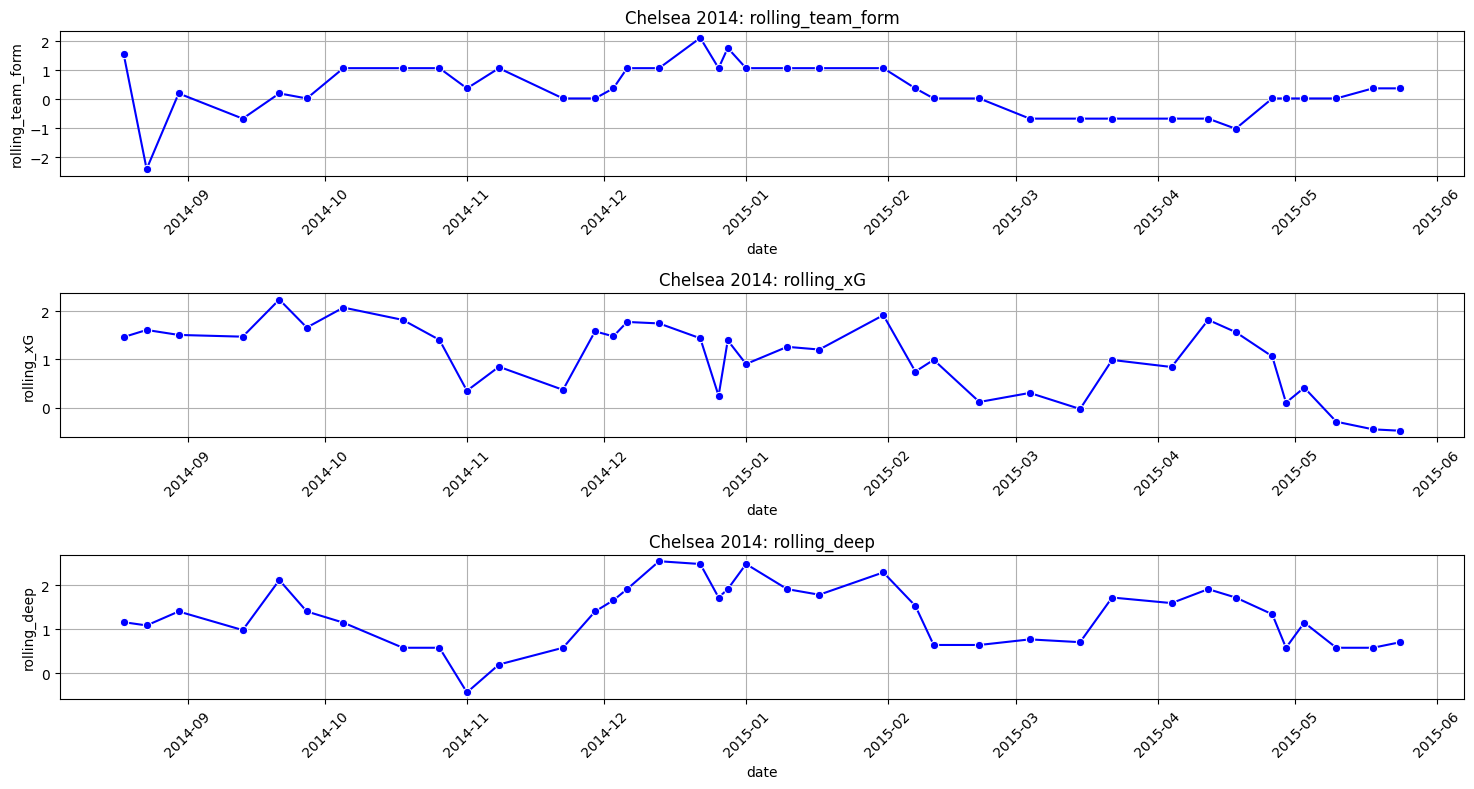

In [30]:

team_data = final_train_df[(train_df['team']== "Chelsea") & (final_train_df['season']== 2014)].sort_values(by='date')

plt.figure(figsize=(15, 8))  # Single figure with subplots

for i, feature in enumerate(['rolling_team_form', 'rolling_xG', 'rolling_deep'], 1):
    plt.subplot(3, 1, i)  # 3 rows, 1 column, position i
    sns.lineplot(data=team_data, x='date', y=feature, marker='o', color='blue')
    plt.title(f"Chelsea 2014: {feature}")
    plt.xticks(rotation=45)
    plt.grid(True)

plt.tight_layout()  # Prevent overlapping labels
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

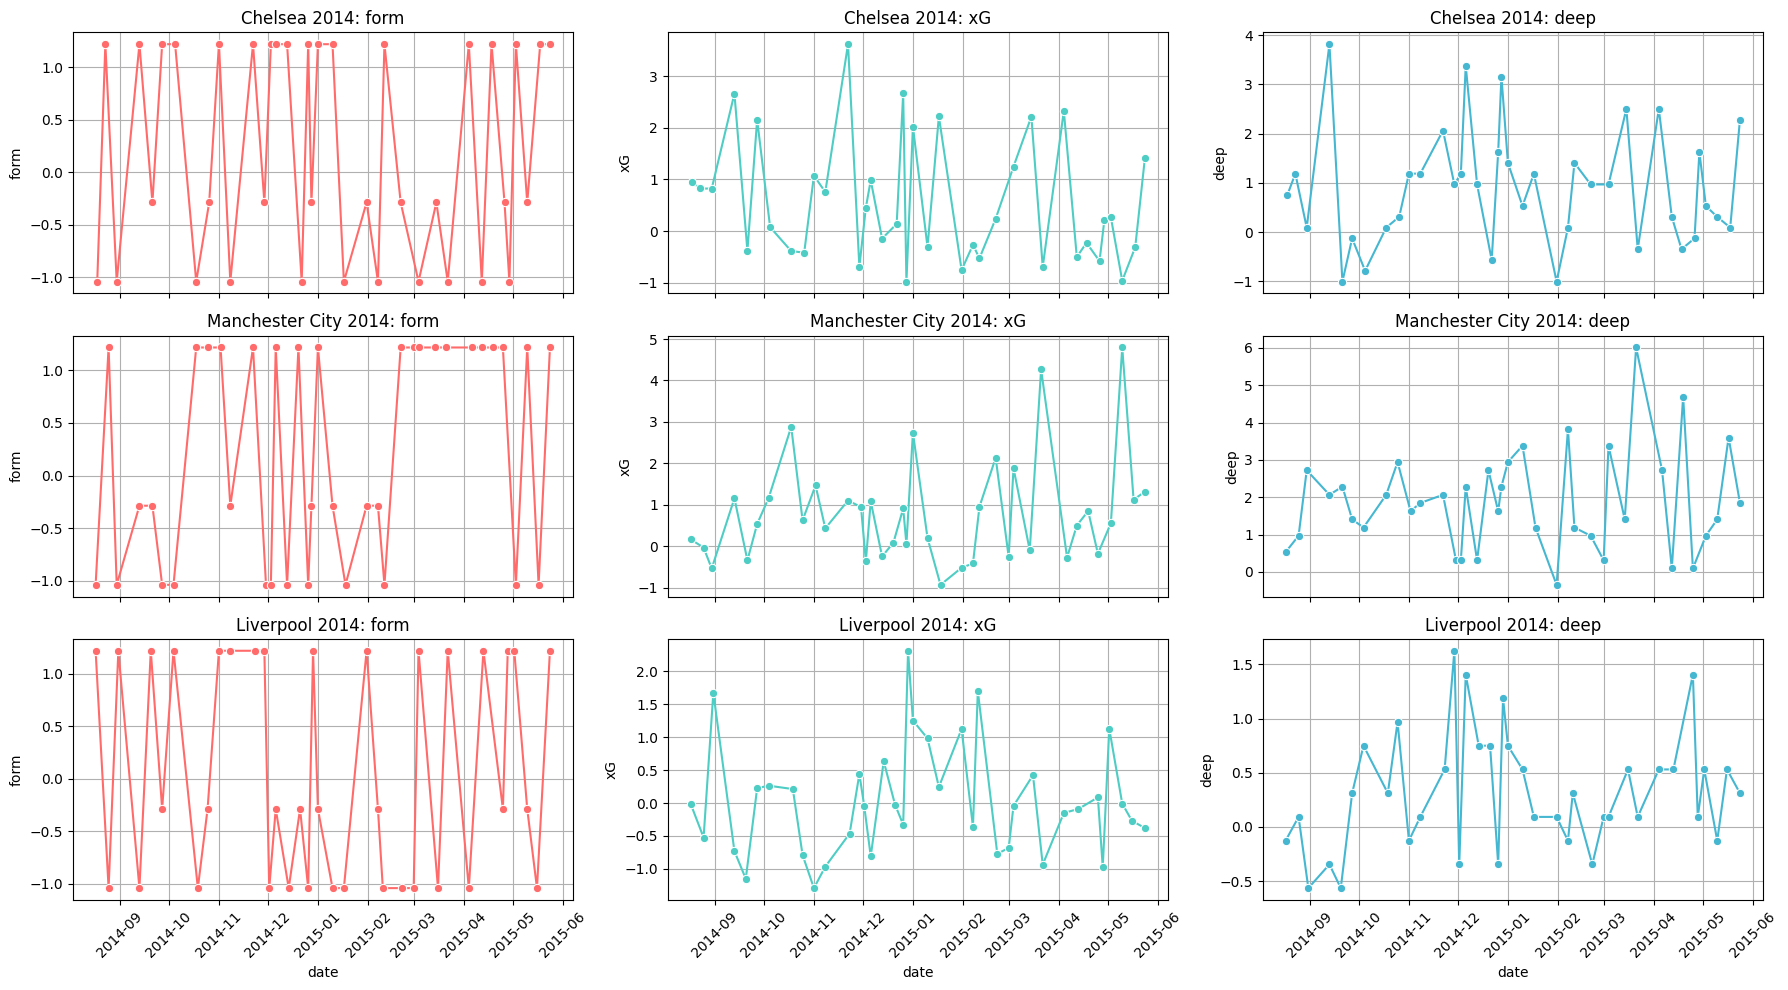

Infinite values in numeric columns:
form                                 0
xG                                   0
shots                                0
shotOnTarget                         0
deep                                 0
possession_proxy                     0
rolling_xG                           0
rolling_shots                        0
rolling_shotOnTarget                 0
rolling_deep                         0
rolling_team_form                    0
rolling_possession_proxy             0
opponent_xG                          0
opponent_shots                       0
opponent_shotOnTarget                0
opponent_deep                        0
opponent_rolling_xG                  0
opponent_rolling_shots               0
opponent_rolling_shotOnTarget        0
opponent_rolling_deep                0
opponent_rolling_team_form           0
opponent_rolling_possession_proxy    0
is_home                              0
final_pos                            0
season                      

In [31]:

# Define teams and features to compare
teams = ["Chelsea", "Manchester City", "Liverpool"]  # Add more teams if needed
features = ['form', 'xG', 'deep']
season = 2014

# Set up subplots: 1 row per team, 3 columns per feature
fig, axes = plt.subplots(len(teams), len(features), figsize=(18, 10), sharex=True)

for i, team in enumerate(teams):
    # Filter team data for the season
    team_data = final_train_df[
        (final_train_df['team'] == team) & 
        (final_train_df['season'] == season)
    ].sort_values(by='date')
    
    for j, feature in enumerate(features):
        ax = axes[i, j]
        sns.lineplot(
            data=team_data, 
            x='date', 
            y=feature, 
            ax=ax,
            marker='o',
            color=['#FF6B6B', '#4ECDC4', '#45B7D1'][j]  # Different colors per feature
        )
        ax.set_title(f"{team} {season}: {feature}")
        ax.set_ylabel(feature)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)

plt.tight_layout()
plt.show()

# Check for infinite values (unchanged from your code)
numeric_cols = final_train_df.select_dtypes(include=[np.number]).columns
inf_counts = (np.isinf(final_train_df[numeric_cols])).sum()
print("Infinite values in numeric columns:")
print(inf_counts)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

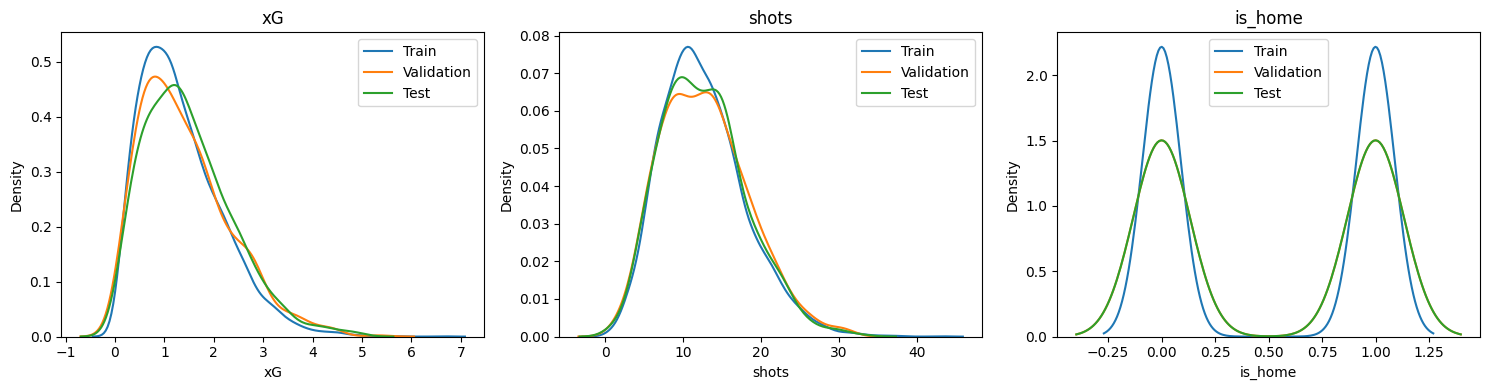

In [32]:
def plot_feature_distributions(features=['xG', 'shots', 'is_home']):
    """Compare feature distributions across train/val/test sets"""
    plt.figure(figsize=(15, 4))
    for i, feature in enumerate(features):
        plt.subplot(1, len(features), i+1)
        sns.kdeplot(train_df[feature], label='Train')
        sns.kdeplot(val_df[feature], label='Validation')
        sns.kdeplot(test_df[feature], label='Test')
        plt.title(feature)
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_feature_distributions()

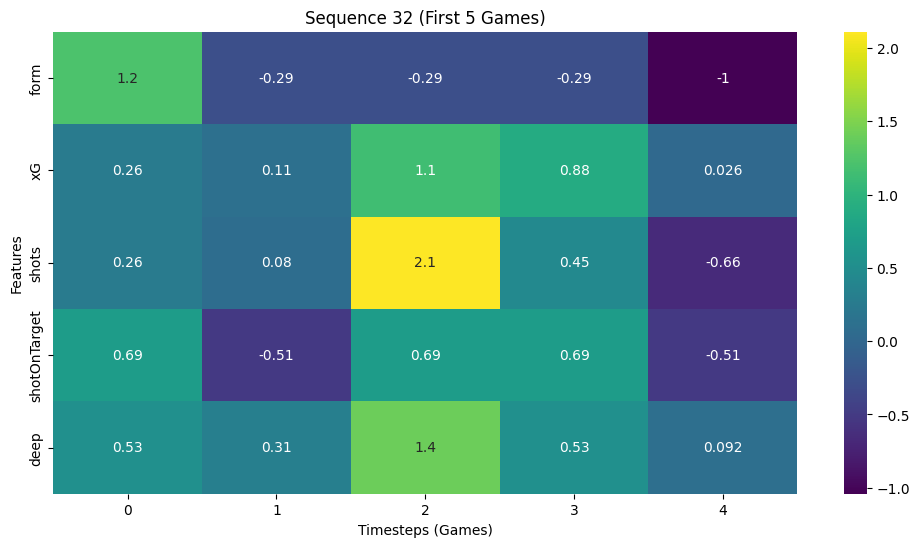

In [33]:
def plot_sequence(sequence_idx, max_timesteps=10, n_features=5):
    """Plot first N timesteps of a sample sequence"""
    plt.figure(figsize=(12, 6))
    
    # Get first sequence (padded)
    sample_seq = X_train[sequence_idx][:max_timesteps, :n_features]
    
    # Create heatmap
    sns.heatmap(sample_seq.T, annot=True, cmap='viridis', 
                yticklabels=feature_cols[:n_features])
    plt.title(f"Sequence {sequence_idx} (First {max_timesteps} Games)")
    plt.xlabel("Timesteps (Games)")
    plt.ylabel("Features")
    plt.show()

# Example: First sequence, first 5 features
plot_sequence(32, max_timesteps=5, n_features=5)

In [34]:
print("Training mean:", scaler.mean_[:5])  # First 5 features' means
print("Training std:", scaler.scale_[:5])  # First 5 features' std devs

# Check test data didn't influence scaling
assert np.allclose(scaler.mean_, train_df[scale_features].mean()), "Data leakage!"

Training mean: [ 1.38176692  1.34038037 12.56860902  4.275       6.57838346]
Training std: [1.32781347 0.83632166 5.41414462 2.49340012 4.56217107]


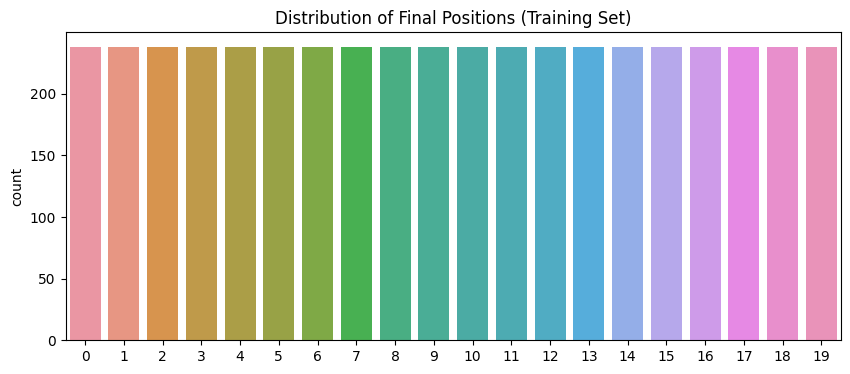

In [35]:
plt.figure(figsize=(10, 4))
sns.countplot(x=y_train)
plt.title("Distribution of Final Positions (Training Set)")
plt.show()

In [36]:
X_train[0][2]

array([-0.28751546,  1.143232  ,  2.1113937 ,  0.6918264 ,  1.4075791 ,
        0.62156284,  0.        ,  0.3103195 ,  0.2841554 ,  0.15356322,
        0.60780144,  1.069515  ,  4.5250654 , -0.6344896 , -0.659127  ,
       -0.5113499 , -0.5651659 , -0.8727595 , -1.2929354 , -0.54901   ,
       -1.7715938 , -1.5400491 , -0.4812879 ], dtype=float32)

In [37]:
print("y_train:", y_train[:35])
print("\nUnique targets:", np.unique(y_train))  # Check possible positions (e.g., 1-20)

y_train: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1]

Unique targets: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding